# INSY 695 - Parametric Models

### Contents
**1. Seasonal ARIMA**

**2. Generalized Additive Model (FbProphet)**

In [89]:
import pandas as pd
import numpy as np
import os
import platform as pf
from IPython.display import display # Display data
pd.options.mode.chained_assignment = None  # default='warn'


import warnings
import itertools    
import statsmodels.api as sm


from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math
from scipy import stats

plt.style.use('fivethirtyeight')

## 1. Load Data 

In [90]:
cwd = os.getcwd()
os_type = pf.system()

import helper
from helper import *

df = load_and_preprocess()


#need to specify datetime[ns] or else the rest will not run 
df['datetime'] = df['datetime'].astype('datetime64[ns]')

In [91]:
weather_df = df[['datetime', 'Temperature']].set_index('datetime')
weather_df['Temperature'] = weather_df['Temperature'] -273.15
weather_df = weather_df.resample('D').mean()
weather_df

,Temperature
datetime,
2012-10-01,12.737980
2012-10-02,13.787931
2012-10-03,14.224583
2012-10-04,13.710833
2012-10-05,14.385208
...,...
2017-11-26,0.257083
2017-11-27,-4.045833
2017-11-28,-6.990958


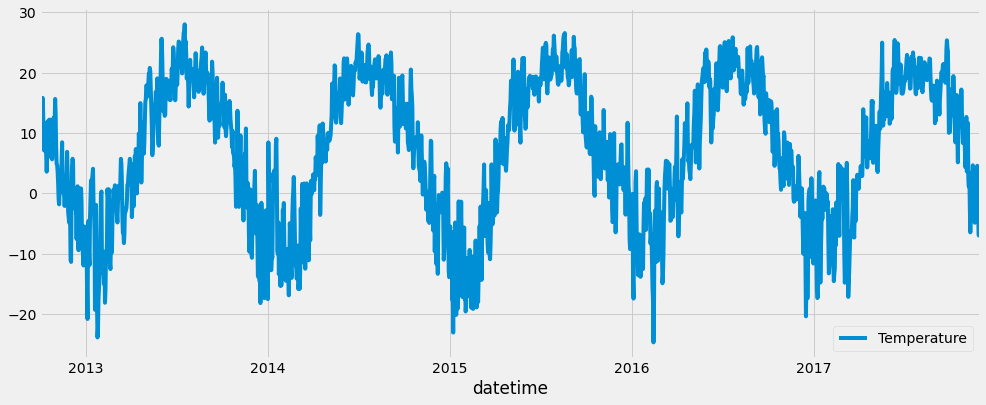

In [92]:
#plot current returns of part X resampled on a mean-returns month to month basis
weather_df.plot(figsize=(15, 6))
plt.show()

## MODEL 1. Seasonal ARIMA 

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.Although the method can handle data with a trend, it does not support time series with a seasonal component. An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**STEP 1: Decompose returns into trend, seasonal, and residual**

Each time series can be decomposed into trend, seasonality, and noise

We can see from the upward trend and annual seasonality that the time series may not be stationary. ARIMA must be stationary (no trends, cycles, random walk, etc.) to work, meaning mean, variance, correlation is constant over time -- if not stationary, transform into period-by-period differences instead.

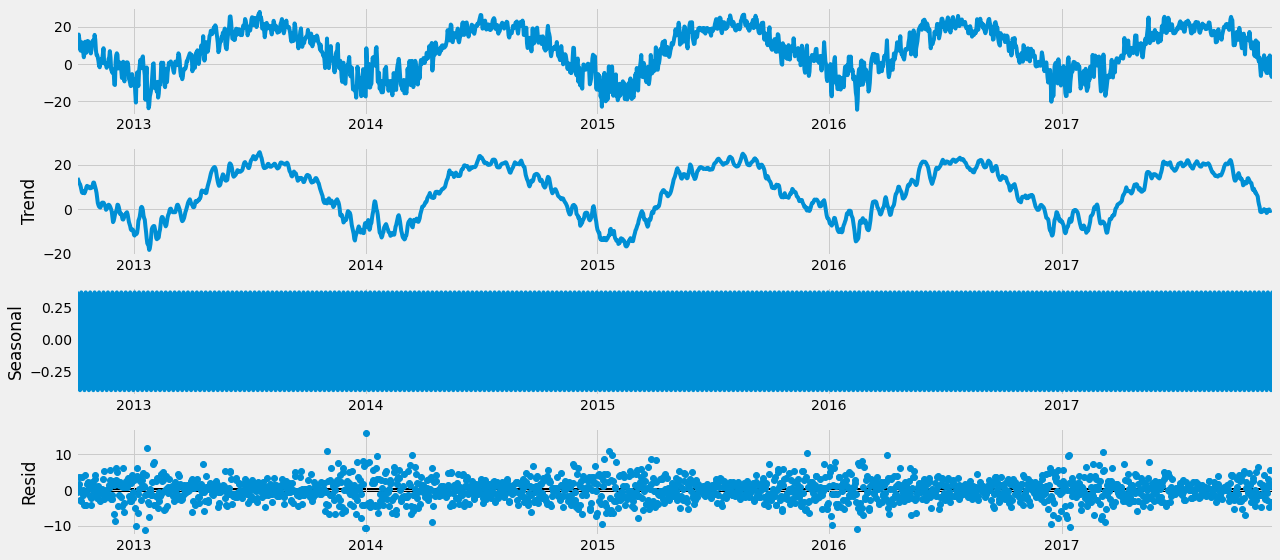

In [93]:
from pylab import rcParams

#decompose observed returns into trend, seasonal, and noise 
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(weather_df, model='additive')
fig = decomposition.plot()
plt.show()

**STEP 2: Run ADF (Augmented Dickey Fuller) Test to check for trend -- the null hypothesis is that the data is not stationary, so if p > 0.05, we can confirm the series is not stationary (there is a trend), and need to do first-order-differencing.**

The data is stationary if its mean, variance, and covariance remain constant over time. For instance, if the trend is upwards over time or the seasonal fluctuations get larger over time, then stationarity would be violated.

In [94]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(weather_df))

Results of Dickey-Fuller Test:
Test Statistic                   -2.352218
p-value                           0.155679
#Lags Used                       13.000000
Number of Observations Used    1873.000000
Critical Value (1%)              -3.433846
Critical Value (5%)              -2.863084
Critical Value (10%)             -2.567592
dtype: float64
None


**STEP 3: Perform first order differencing**

Rerunning the test again after performing first order differencing confirms that the trend is now stationary.

Results of Dickey-Fuller Test:
Test Statistic                -1.771203e+01
p-value                        3.498802e-30
#Lags Used                     1.200000e+01
Number of Observations Used    1.873000e+03
Critical Value (1%)           -3.433846e+00
Critical Value (5%)           -2.863084e+00
Critical Value (10%)          -2.567592e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -6.981500e+00
p-value                        8.169863e-10
#Lags Used                     2.400000e+01
Number of Observations Used    1.850000e+03
Critical Value (1%)           -3.433890e+00
Critical Value (5%)           -2.863104e+00
Critical Value (10%)          -2.567602e+00
dtype: float64
None


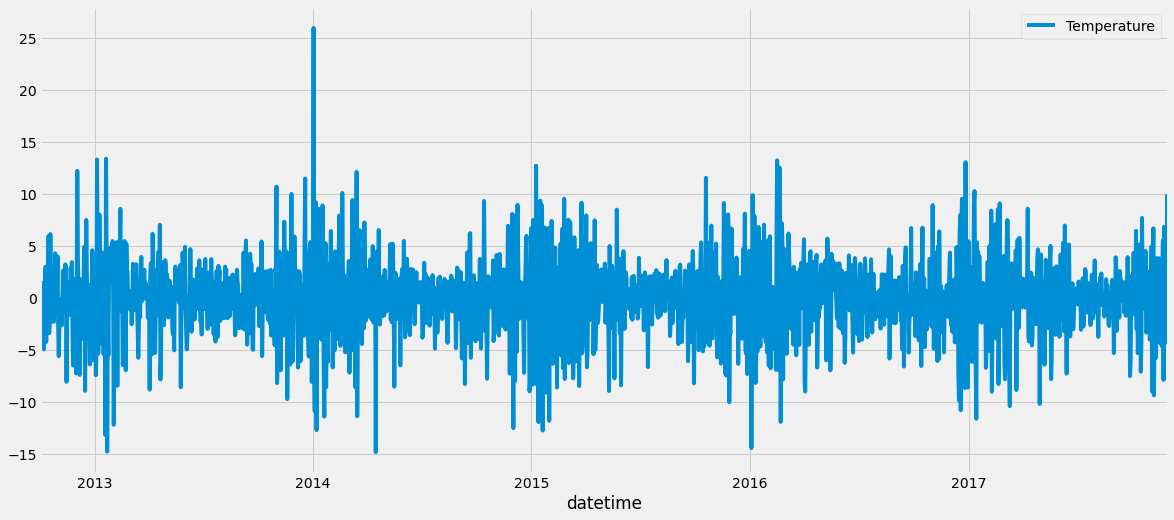

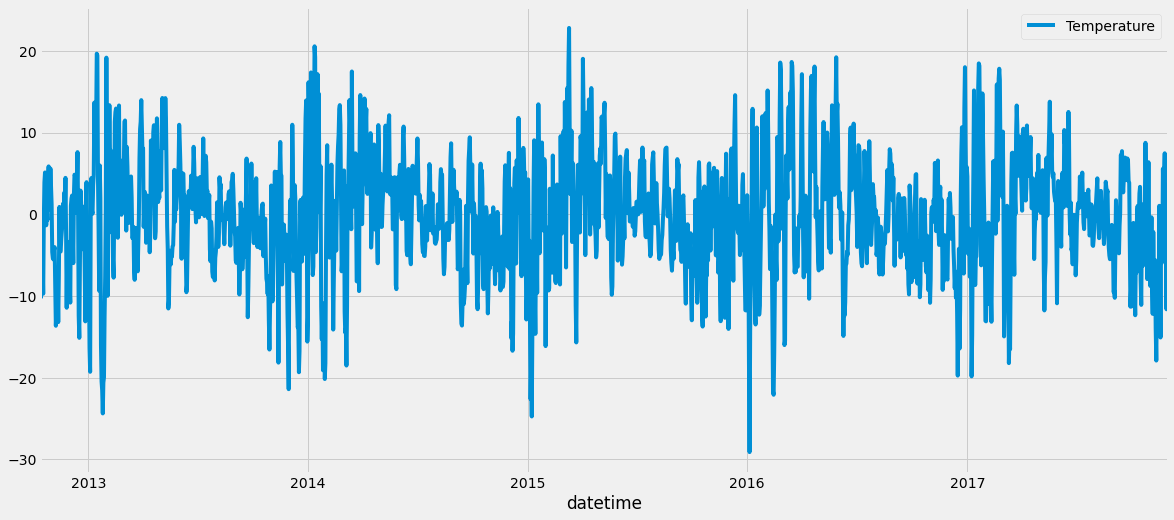

In [95]:
def differencing_func(y):
    #FIRST ORDER DIFFERENCING
    y_adj = y - y.shift(1)
    y_adj = y_adj.dropna()
    y_adj.plot()

    #SEASONAL DIFFERENCING 
    y_adj2 = y - y.shift(12)
    y_adj2 = y_adj2.dropna()
    y_adj2.plot()

    print(adf_test(y_adj))
    print(adf_test(y_adj2))
    
differencing_func(weather_df)

**Step 4: Plot ACF and PACF**

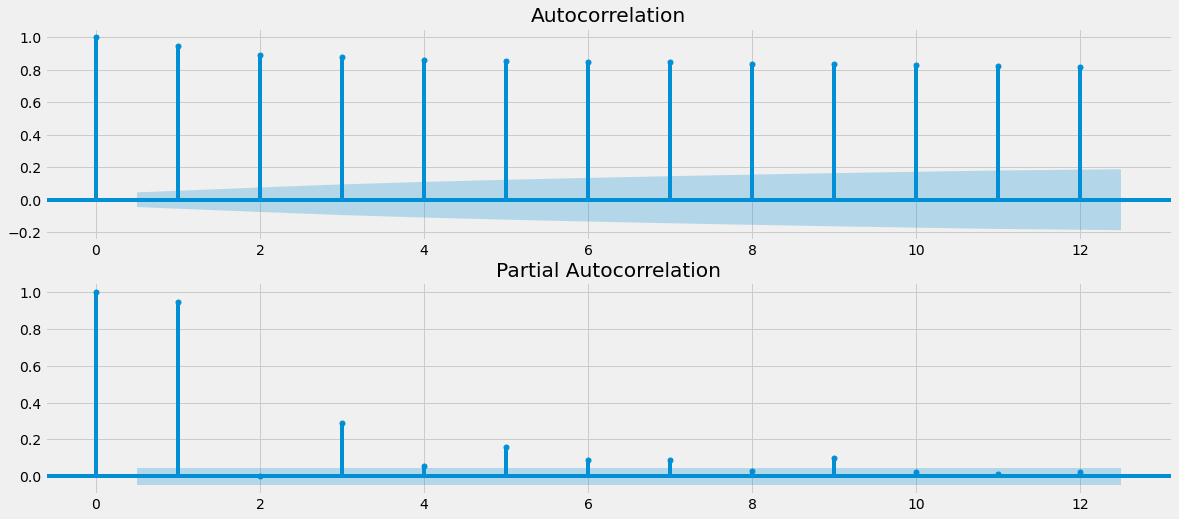

In [96]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(weather_df, lags=12, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(weather_df, lags=12, ax=ax[1])
plt.show()

**STEP 5: Specify SARIMA(p,d,q)*(P,D,Q,s)** 
- **p and seasonal P** = number of AUTOREGRESSIVE terms (lags of the stationarized series). It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- **d and seasonal D**: DIFFERENCING that must be done to stationarize the series. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- **q and seasonal Q**: indicate number of MOVING AVERAGE terms -- lags of the forecast errors. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
- **s**: seasonal length in the data

- (p,q,d) are the non seasonal parameters and (P,Q,D) follow the same definition but are applied to the seasonal component.

This process of gridsearch will let the model automatically find the best parameters to make the ARIMA stationary. We use gridsearch since we are unsure of the actual parameters!

In [97]:
#since we are doing a seasonal ARIMA, we must specify parameters for ARIMA and SARIMA

#create combinations of ARIMA parameters
p = d = q = range(0, 2)
s = (1,12)

#create combinations of non-seasonal parameters 
pdq = list(itertools.product(p, d, q))

#create combinations for seasonal parameters -- 12 for monthly data
seasonal_pdq = list(itertools.product(p,d,q,s))


#print out sample of results
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 1)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 1)


In [98]:
grid_search = pd.DataFrame(columns = ['param', 'param_seasonal', 'AIC'])

warnings.filterwarnings("ignore") # specify to ignore warning messages
#loop through parameters and seasonal parameters and perform a grid search
for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try:
            model = sm.tsa.statespace.SARIMAX(weather_df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = model.fit(max_iter = 50, method = 'powell') #optimizer method 
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #append results to grid search df 
            grid_search = grid_search.append({'param': param, 'param_seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)
        
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.026690
         Iterations: 1
         Function evaluations: 21
SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:15198.72850648301
Optimization terminated successfully.
         Current function value: 3.710701
         Iterations: 2
         Function evaluations: 47
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:14008.18451310846
Optimization terminated successfully.
         Current function value: 3.339837
         Iterations: 1
         Function evaluations: 11
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:12606.544358595125
Optimization terminated successfully.
         Current function value: 3.281450
         Iterations: 2
         Function evaluations: 46
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:12388.191119569172
Optimization terminated successfully.
         Current function value: 3.329798
         Iterations: 1
         Function evaluations: 26
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:12570.658644809319
Optimization terminated successfully.

In [99]:
#extract the best parameters for model
best_param =  grid_search.sort_values(by = 'AIC').reset_index()['param'][0]
best_seasonal_param = grid_search.sort_values(by = 'AIC').reset_index()['param_seasonal'][0]
grid_search.sort_values(by = 'AIC').reset_index()

,index,param,param_seasonal,AIC
0,57,"(1, 1, 1)","(0, 0, 1, 12)",10172.838315
1,60,"(1, 1, 1)","(1, 0, 0, 12)",10172.945396
2,63,"(1, 1, 1)","(1, 1, 1, 12)",10173.659433
3,61,"(1, 1, 1)","(1, 0, 1, 12)",10175.151251
4,56,"(1, 1, 1)","(0, 0, 0, 12)",10178.928853
...,...,...,...,...
59,4,"(0, 0, 0)","(1, 0, 0, 12)",12570.658645
60,2,"(0, 0, 0)","(0, 1, 0, 12)",12606.544359
61,8,"(0, 0, 1)","(0, 0, 0, 12)",13114.639298
62,1,"(0, 0, 0)","(0, 0, 1, 12)",14008.184513


**STEP 6: Run SARIMAX**

In [100]:
model = sm.tsa.statespace.SARIMAX(weather_df,
                                order= best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,    #defaults, but not necessary
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6151      0.028     21.610      0.000       0.559       0.671
ma.L1         -0.8752      0.018    -49.635      0.000      -0.910      -0.841
ma.S.L12      -0.0674      0.021     -3.244      0.001      -0.108      -0.027
sigma2        12.8812      0.319     40.357      0.000      12.256      13.507


**Check Model Fit** 
- Residuals: should be uncorrelated with a mean of 0, if there are correlations, there is information in them that should be used in computing forecasting. We can see that there is no correlation and zero mean.
- Correlogram: residuals have relatively low corerlation with lagged versions of itself

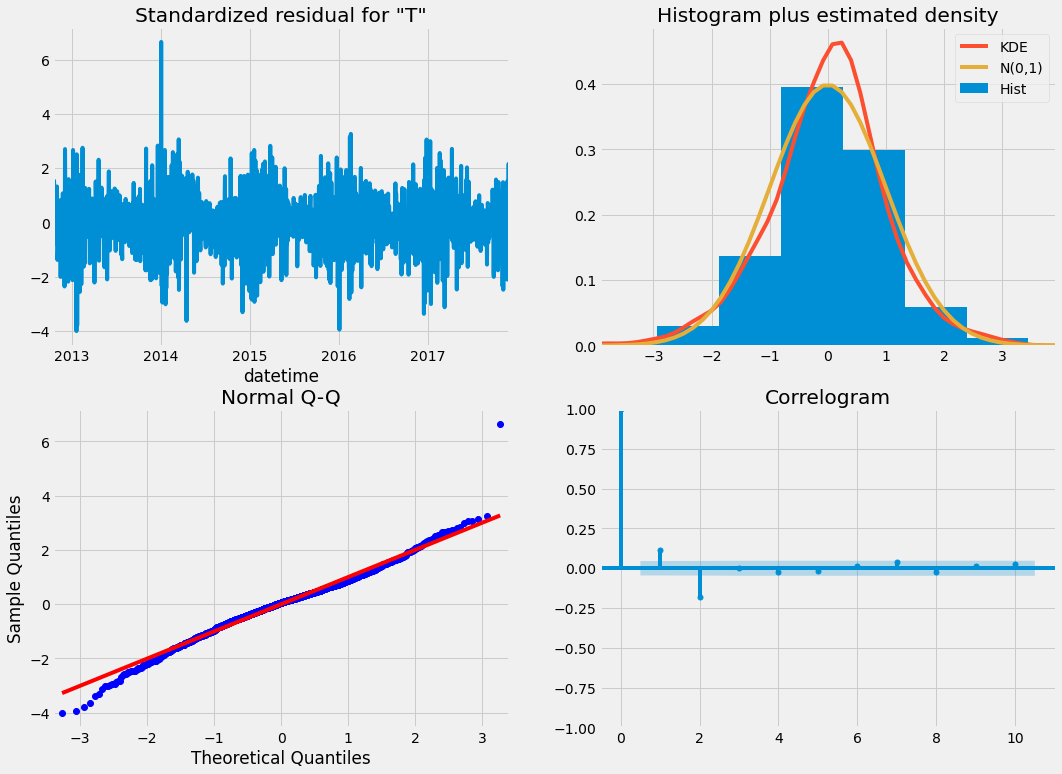

In [101]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

**STEP 7: Generate Predictions**

- dynamic: True = uses data from predicted points to generate future forecasts; False = generates one step ahead forecasts, i.e. uses only past data that we have to generate predicted forecasts
    - If we are only generating predictions for one month, then this should not matter

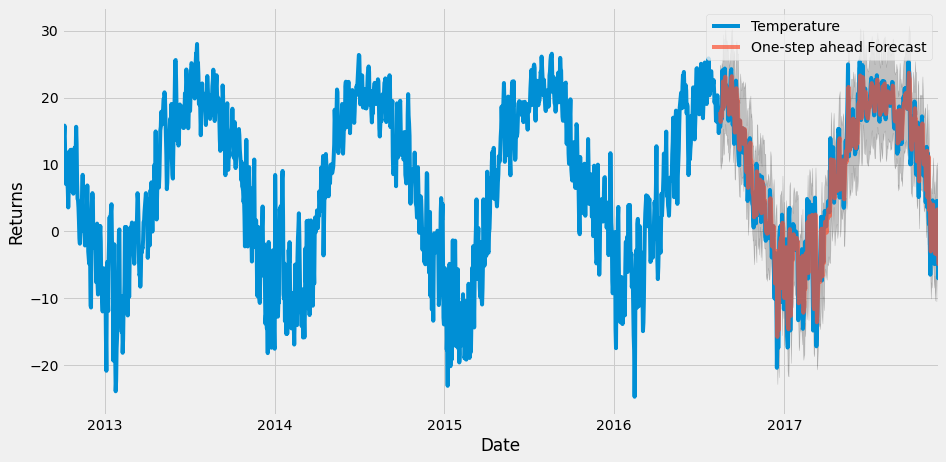

In [102]:
#user can set predicted values to when they want the prediction to start 
prediction_start_date = weather_df.iloc[int(len(weather_df)*0.75)].name
#predict to the end of the dataset 
prediction_end_date = pd.to_datetime(weather_df.index[-1])



#generate predicted results and store 
pred = results.get_prediction(start=prediction_start_date, end = prediction_end_date, dynamic=False)

#predicted vs truth for time period in question -- if the forecast is negative, change to 0 
predicted = pred.predicted_mean

observed = weather_df[prediction_start_date:]
#confidence interval
ci = pred.conf_int()

#plot real against predicted values
ax = weather_df.plot(label='observed')
predicted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
plt.legend()
plt.show()

In [103]:
ts_results = pd.DataFrame({'Predicted': predicted.values, 'CI Lower': ci['lower Temperature'], 'CI Upper': ci['upper Temperature'], 'Observed': observed['Temperature'].values})

#get MAE -- calculate afterwards due to zeroing
ts_results['MAE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'].values)**2)
        
#MAE of the entire prediction period 
MAE_total = ts_results['MAE'].mean()
MAE_total

2.57959133159389

In [104]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,CI Lower,CI Upper,Observed,MAE
datetime,,,,,
2016-08-16 00:00:00,17.850274,10.815895,24.884652,15.592083,2.258190
2016-08-17 00:00:00,16.362536,9.328157,23.396914,16.340833,0.021702
2016-08-18 00:00:00,16.865773,9.831395,23.900152,17.878867,1.013094
2016-08-19 00:00:00,18.112099,11.077721,25.146477,16.735417,1.376682
2016-08-20 00:00:00,17.130230,10.095851,24.164608,19.421667,2.291437
2016-08-21 00:00:00,18.910866,11.876487,25.945244,24.077500,5.166634
2016-08-22 00:00:00,22.410499,15.376120,29.444877,18.232083,4.178415
2016-08-23 00:00:00,18.458774,11.424396,25.493153,18.570000,0.111226
2016-08-24 00:00:00,18.722613,11.688235,25.756992,22.578750,3.856137


## MODEL 2. AutoARIMA


AutoARIMA is the least-specific base ARIMA model to generate a baseline prediction.

Usually, in the basic ARIMA model, we need to provide the p,d, and q values which are essential. We use statistical techniques to generate these values by performing the difference to eliminate the non-stationarity and plotting ACF and PACF graphs. In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting.

**NOTE: AUTOARIMA CRASHES DUE TO DATA SIZE -- NOT CONTINUED** 

In [105]:
from pmdarima.utils import tsdisplay 
from pmdarima.arima import auto_arima
import pmdarima as pm

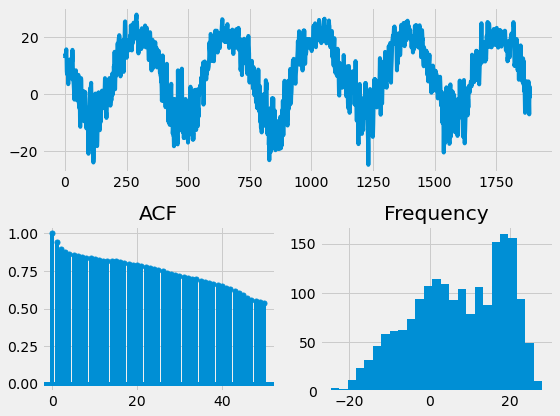

In [106]:
from pmdarima.utils import tsdisplay 
tsdisplay(weather_df)

## MODEL 3. GAM using FbProphet 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

According to FB's paper, FbProphet is a decomposable time-series with 3 main components: trend, seasonality, and holidays. FbProphet is specified similar to a generalized additive model (GAM) -- which are regression models with potential non-linear smoothers applied to the regressors. IT can decompose easily and accomodate new components when they are introduced -- i.e. if a new source of seasonality is identified. Since GAM frames the forecating problem as a curve fitting exercise, it is different from ARIMA that accounts for the temporal dependence structure in the data -- so it is inferentially weaker than a generative model such as ARIMA. However, it is more flexible (can accomodate seasonality with multiple periods), measurements do not need to be regularly spaced (so missing values do not need to be interpolated), and fitting is faster.

https://peerj.com/preprints/3190/
https://facebook.github.io/prophet/

In [107]:
from fbprophet import Prophet

In [108]:
#Reformat to FbProphet Format
y_prophet = pd.DataFrame({'ds': weather_df.index, 'y': weather_df['Temperature'].values}).reset_index().drop('index', axis = 1)
y_prophet

,ds,y
0,2012-10-01,12.737980
1,2012-10-02,13.787931
2,2012-10-03,14.224583
3,2012-10-04,13.710833
4,2012-10-05,14.385208
...,...,...
1882,2017-11-26,0.257083
1883,2017-11-27,-4.045833
1884,2017-11-28,-6.990958
1885,2017-11-29,2.847917


In [109]:
#split data 
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y_prophet)*0.75)
train, test = train_test_split(y_prophet, split_len)

In [110]:
model = Prophet(yearly_seasonality = True, interval_width=0.95)
model.fit(train)

#in prophet, if you pass in historical dates it will provide an in-sample fit
forecast = model.make_future_dataframe(periods = len(test), freq = 'D')

results_df = model.predict(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
#filter results down to test-dataset only 
results_filtered = results_df[['ds','yhat','yhat_lower','yhat_upper']].iloc[split_len:]

In [112]:
ts_results = pd.DataFrame({'Predicted' : results_filtered['yhat'].values, 'CI Lower': results_filtered['yhat_lower'].values, 'CI Upper':results_filtered['yhat_upper'].values , 'Observed': test['y'].values}, index = test['ds'])

ts_results['MAE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'])**2)
MAE_total = ts_results['MAE'].mean()
MAE_total

3.750670212255643

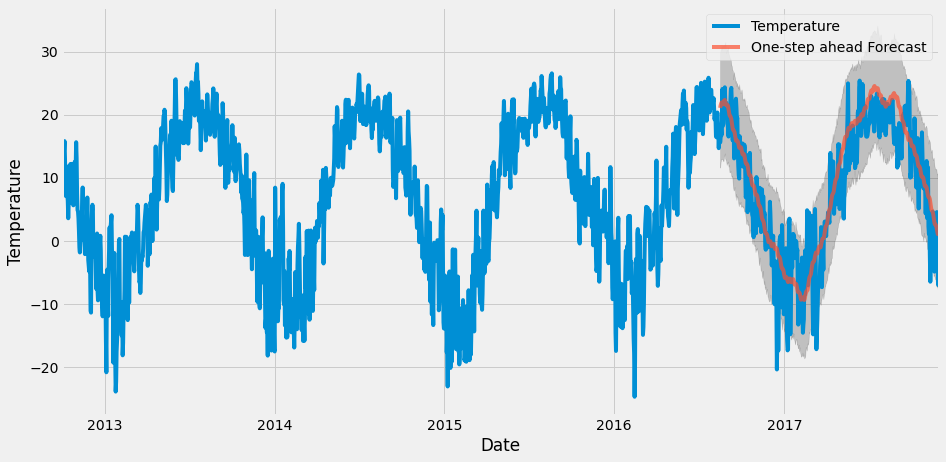

In [113]:
#plot real against predicted values
ax = weather_df.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


ax.fill_between(ts_results.index,
                ts_results['CI Lower'],
                ts_results['CI Upper'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

In [114]:
ts_results.head(20).style.background_gradient(cmap='inferno')

,Predicted,CI Lower,CI Upper,Observed,MAE
ds,,,,,
2016-08-16 00:00:00,21.066296,11.613627,29.864374,15.592083,5.474213
2016-08-17 00:00:00,21.475613,12.566377,30.307374,16.340833,5.134779
2016-08-18 00:00:00,21.733801,12.896630,30.403635,17.878867,3.854933
2016-08-19 00:00:00,21.934060,13.016940,31.029400,16.735417,5.198644
2016-08-20 00:00:00,21.819717,12.963422,30.297149,19.421667,2.398051
2016-08-21 00:00:00,21.757400,12.946421,30.858402,24.077500,2.320100
2016-08-22 00:00:00,21.637884,12.780772,30.938053,18.232083,3.405801
2016-08-23 00:00:00,21.828441,12.607273,30.703342,18.570000,3.258441
2016-08-24 00:00:00,22.138206,13.273500,31.012597,22.578750,0.440544
